In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import shutil
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# implementing  custom U-net

### standard U-Net 구현

- 주요 함수 :  
1. layers.Cropping2D(cropping=((top_crop, bottom_crop), (left_crop, right_crop)))  
2. upconv_block(inputs, filters, kernel_size=2):  
    x = layers.UpSampling2D(size=(2, 2))(inputs)  
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)


## Function

In [ ]:
Index2Label = {0: 'Background', 
               1: 'Head', 
               2: 'Torso', 
               3: 'Upper_Arms', 
               4: 'Lower_Arms', 
               5: 'Upper_Legs', 
               6: 'Lower_Legs'}

Label2Index = {'Background': 0, 
               'Head': 1, 
               'Torso': 2, 
               'Upper_Arms': 3, 
               'Lower_Arms': 4, 
               'Upper_Legs': 5, 
               'Lower_Legs': 6}

# Label2Index = {v: k for k, v in Index2Label.items()}

In [3]:
def create_images_path(folder_path):
    folder_path = folder_path
    imges = os.listdir(folder_path)
    images_path = [os.path.join(folder_path, img) for img in imges]
    return images_path

In [7]:
def visualize_images(images_path, visualize=1, rotate=0): # Outputs\\01_01_F010_02.png, rotate 회전각 입력
    # Output
    images_names = []
    images_array = []
    
    for img in tqdm(images_path, desc="Processing images"):
        image_path = img
        image_name = os.path.basename(image_path)

        image = Image.open(image_path)

        # 이미지 회전 메타데이터를 자동으로 해석하여 회전시킴
        image = image.rotate(rotate, expand=True)  # 0은 회전 각도, expand=True는 이미지 크기 조정 (0 / 270)

        images_names.append(image_name)
        image_array = np.array(image)
        images_array.append(image_array)

        # Visualize Images -------------------> Option(On/Off)
        if visualize:
            
            print("Size of Image:", image.size)
            print("Mode of Image:", image.mode) # (RGB/L/P)
            
            # print("Shape of Image (Numpy ):", )
            
            
            plt.imshow(image)
            plt.title(f'{image_name}')
            plt.axis('off')  # 축 제거
            plt.show()
    else:
        pass

    return images_names, images_array

In [ ]:
def palette_to_one_hot(palette_image_path, num_classes=7, imge_info=True, visualize=True):
    """
    팔레트 이미지를 원핫인코딩하여 (2940, 1960, 7) 형태의 이미지로 변환하는 함수

    Args:
    palette_image_path (str): 세그멘테이션된 P 모드의 PIL 팔레트 이미지 경로

    Returns:
    np.ndarray: 원핫인코딩된 이미지
    """
    # 클래스 수 정의 (배경 포함 1개)
    num_classes = num_classes

    # PIL 2 Numpy
    palette_image = Image.open(palette_image_path)
    palette_image_array = np.array(palette_image)

    # 원핫인코딩된 이미지를 저장할 배열 생성
    one_hot_encoded_image = np.zeros((*palette_image_array.shape, num_classes), dtype=np.uint8)

    # 각 픽셀을 원핫인코딩된 형태로 변환
    for i in range(palette_image_array.shape[0]): # 2940
        for j in range(palette_image_array.shape[1]): # 1960
            pixel_value = palette_image_array[i, j]  # 현재 픽셀의 값
            one_hot_encoded_image[i, j, pixel_value] = 1  # 해당 클래스에 대응하는 채널에 1 할당

    if imge_info:
        # 이미지 이름 출력
        image_name = os.path.basename(palette_image_path)
        print("Image Name:", image_name)
        print("Original Image Shape:", palette_image_array.shape)
        print("Transformed Image Shape:", one_hot_encoded_image.shape)
        print()
        
    if visualize:
        visualize_one_hot_encoded_image(one_hot_encoded_image,  Index2Label=Index2Label)
        
    return one_hot_encoded_image

In [ ]:
def visualize_one_hot_encoded_image(one_hot_encoded_image, Index2Label=Index2Label):
    """
    원핫인코딩된 이미지를 시각화하고 클래스별로 따로 시각화하여 보여주는 함수

    Args:
    one_hot_encoded_image (np.ndarray): 원핫인코딩된 이미지

    Returns:
    None
    """
    # 이미지의 형태 출력
    print("Transformed Image Shape:", one_hot_encoded_image.shape)

    # 전체 이미지 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(one_hot_encoded_image.argmax(axis=2), cmap='viridis', interpolation='nearest')
    plt.title('Original Palette Image')
    plt.axis('off')
    plt.show()

    # 클래스별로 따로 시각화
    num_classes = one_hot_encoded_image.shape[2]
    for class_index in range(num_classes):
        class_image = one_hot_encoded_image[:, :, class_index]
        plt.figure(figsize=(8, 8))
        plt.imshow(class_image, cmap='gray')
        plt.title(f'Class: {class_index} {Index2Label[class_index]}')
        plt.axis('off')
        plt.show()

In [ ]:
def save_images_pkl_with_one_hot_encoding(images_paths, output_folder_path, num_classes=7, imge_info=True, visualize=False):
    """
    이미지를 원핫인코딩하여 새로운 폴더에 저장하는 함수

    Args:
    images_paths (list): 이미지 파일 경로의 리스트
    output_folder_path (str): 이미지를 저장할 폴더 이름(현재 경로에 저장)
    num_classes (int): segmentation 세그멘테이션 클래스 개수(배경 포함)
    imge_info (bool): 이미지 정보 출력 토글(default: True)
    visualize (bool): 이미지 시각화 토글(default: False)

    Returns:
    None
    """
    # 새로운 폴더 생성
    os.makedirs(output_folder_path, exist_ok=True)
    
    # one_hot_encoded_images
    one_hot_encoded_images = []

    # 원핫 인코딩 수행
    for img_path in tqdm(images_paths, desc='Encoding images'):
        
        # PIL Pallete 2 Numpy
        one_hot_encoded_image = palette_to_one_hot(img_path, num_classes=num_classes, imge_info=imge_info, visualize=visualize)
        one_hot_encoded_images.append(one_hot_encoded_image)
        
    # 저장할 경로 설정
    save_path = os.path.join(output_folder_path, f"one_hot_encoded_images_array.pkl") 
        
    # 이미지 데이터를 피클로 저장
    with open(save_path, 'wb') as f:
        pickle.dump(one_hot_encoded_images, f)

# Task

In [5]:
# 피클 파일 경로
pickle_file_path = "one_hot_encoded_images_array.pkl"

# 피클 파일 불러오기
with open(pickle_file_path, 'rb') as f:
    one_hot_encoded_images = pickle.load(f)

# 저장된 데이터 확인
print("Number of images:", len(one_hot_encoded_images))
print("Shape of each image:", one_hot_encoded_images[0].shape)

print(type(one_hot_encoded_images))
print(type(one_hot_encoded_images[0]))

Number of images: 10
Shape of each image: (2940, 1960, 7)
<class 'list'>
<class 'numpy.ndarray'>


In [4]:
origin_images_path = create_images_path("test_orgin_images")
origin_images_path

['test_orgin_images\\01_00_F001_01.jpg',
 'test_orgin_images\\01_00_F002_01.jpg',
 'test_orgin_images\\01_00_F003_01.jpg',
 'test_orgin_images\\01_00_M002_01.jpg',
 'test_orgin_images\\01_01_F001_01.jpg',
 'test_orgin_images\\01_01_F002_01.jpg',
 'test_orgin_images\\01_01_F003_01.jpg',
 'test_orgin_images\\01_01_F004_01.jpg',
 'test_orgin_images\\01_01_F017_01.jpg',
 'test_orgin_images\\01_01_F018_01.jpg']

In [ ]:
imges_name, imges_array = visualize_images(origin_images_path, visualize=True, rotate=270)

In [9]:
imges_name

['01_00_F001_01.jpg',
 '01_00_F002_01.jpg',
 '01_00_F003_01.jpg',
 '01_00_M002_01.jpg',
 '01_01_F001_01.jpg',
 '01_01_F002_01.jpg',
 '01_01_F003_01.jpg',
 '01_01_F004_01.jpg',
 '01_01_F017_01.jpg',
 '01_01_F018_01.jpg']

In [ ]:
# 이미지 리사이즈 및 패딩 적용
# resized_image = tf.image.resize_with_pad(image_tensor, target_height, target_width)

In [11]:
X = []

for image_array in imges_array:
    resized_array = resized_padded_image = tf.image.resize_with_pad(image_array, target_height=512, target_width=512).numpy()
    X.append(resized_array)
    
X = np.array(X)
X.shape

(10, 512, 512, 3)

In [12]:
y = []

for seg_array in one_hot_encoded_images:
    resized_array = resized_padded_image = tf.image.resize_with_pad(seg_array, target_height=512, target_width=512).numpy()
    y.append(resized_array)
    
y = np.array(y)
y.shape

(10, 512, 512, 7)

In [13]:
print(type(X), type(y))
print(X.shape, y.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(10, 512, 512, 3) (10, 512, 512, 7)


In [16]:
import tensorflow as tf
from tensorflow.keras import layers

def conv_block(inputs, filters, kernel_size=3):
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

def upconv_block(inputs, filters, kernel_size=2):
    x = layers.UpSampling2D(size=(2, 2))(inputs)
    x = layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

def unet(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))

    # Contracting Path
    c1 = conv_block(inputs, 64, kernel_size=3)
    p1 = layers.MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, 128, kernel_size=3)
    p2 = layers.MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, 256, kernel_size=3)
    p3 = layers.MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, 512, kernel_size=3)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    # Bottom
    b = conv_block(p4, 1024, kernel_size=3)

    # Expanding Path
    u1 = upconv_block(b, 512, kernel_size=2)
    u1_concat = layers.Concatenate()([u1, c4])
    c5 = conv_block(u1_concat, 512, kernel_size=3)

    u2 = upconv_block(c5, 256, kernel_size=2)
    u2_concat = layers.Concatenate()([u2, c3])
    c6 = conv_block(u2_concat, 256, kernel_size=3)

    u3 = upconv_block(c6, 128, kernel_size=2)
    u3_concat = layers.Concatenate()([u3, c2])
    c7 = conv_block(u3_concat, 128, kernel_size=3)

    u4 = upconv_block(c7, 64, kernel_size=2)
    u4_concat = layers.Concatenate()([u4, c1])
    c8 = conv_block(u4_concat, 64, kernel_size=3)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c8)

    return tf.keras.Model(inputs, outputs)

# Clearing previous sessions
# tf.keras.backend.clear_session()

# Defining input image size and number of classes
img_size = (512, 512)
num_classes = 7


In [17]:
# tf.keras.backend.clear_session()

model = unet(img_size, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [18]:
# X = X[:2]
# y = y[:2]
X.shape, y.shape

((10, 512, 512, 3), (10, 512, 512, 7))

In [59]:
hist = model.fit(X, y)

ResourceExhaustedError: Graph execution error:

Detected at node 'model/conv2d_16/Relu' defined at (most recent call last):
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\kernelapp.py", line 701, in start
      self.io_loop.start()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\asyncio\windows_events.py", line 316, in run_forever
      super().run_forever()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue
      await self.process_one()
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one
      await dispatch(*args)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell
      await result
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request
      reply_content = await reply_content
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute
      res = shell.run_cell(
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\JAY\AppData\Local\Temp\ipykernel_29708\1317976882.py", line 1, in <module>
      hist = model.fit(X, y)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\JAY\anaconda3\envs\TF_GPU_RTX\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/conv2d_16/Relu'
OOM when allocating tensor with shape[2,256,256,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/conv2d_16/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_13877]

ValueError: operands could not be broadcast together with shapes (10,) (9,) 

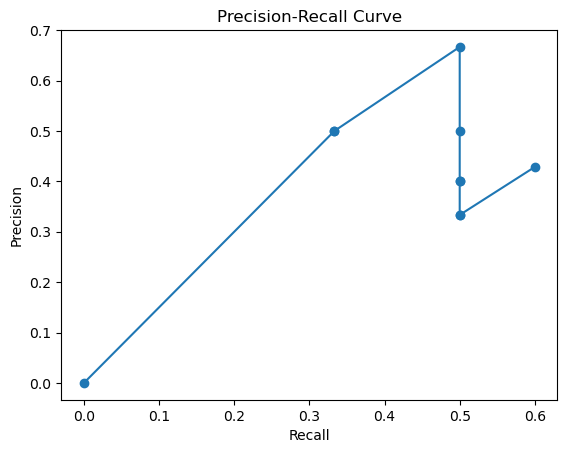

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 예측 결과와 실제 레이블
predictions = np.array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1])  # 1: 마스크 쓴 것, 0: 마스크 안 쓴 것
labels = np.array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])  # 실제 레이블

# 예측 결과가 1일 때의 확률을 저장
scores = np.array([0.9, 0.8, 0.2, 0.9, 0.7, 0.6, 0.3, 0.9, 0.4, 0.8])

# 정밀도(Precision)와 재현율(Recall) 계산
true_positives = np.cumsum((predictions == 1) & (labels == 1))
false_positives = np.cumsum((predictions == 1) & (labels == 0))
false_negatives = np.sum((predictions == 0) & (labels == 1))
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

# PR 곡선 그리기
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# PR 곡선 아래 면적(AP) 계산
ap = np.sum(precision * (recall[1:] - recall[:-1]))
print("Average Precision (AP):", ap)

plt.show()


Average Precision (AP): 0.2130952380952381


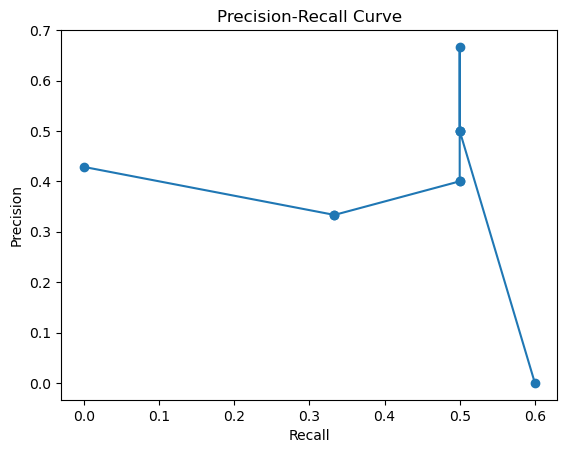

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 주어진 예측 결과와 실제 레이블
predictions = np.array([1, 1, 0, 1, 1, 1, 0, 1, 0, 1])  # 1: 마스크 쓴 것, 0: 마스크 안 쓴 것
labels = np.array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1])  # 실제 레이블

# 예측 결과가 1일 때의 확률을 저장
scores = np.array([0.9, 0.8, 0.2, 0.9, 0.7, 0.6, 0.3, 0.9, 0.4, 0.8])

# 정밀도(Precision)와 재현율(Recall) 계산
true_positives = np.cumsum((predictions == 1) & (labels == 1))
false_positives = np.cumsum((predictions == 1) & (labels == 0))
false_negatives = np.sum((predictions == 0) & (labels == 1))
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)

# precision을 역순으로 정렬
precision = precision[::-1]

# PR 곡선 그리기
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# PR 곡선 아래 면적(AP) 계산
ap = np.trapz(precision, recall)
print("Average Precision (AP):", ap)

plt.show()


In [5]:
path = r"D:\알파코\SCHP\Jay's_code\resize_pad_img\512,512\512,512\01_00_F001_01.jpg"

test_image = Image.open(path)

test_array = np.array(test_image)

test_array.shape

(512, 512, 3)